In [2]:
%matplotlib inline
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
from torchsummary import summary
import numpy as np
import pandas as pd
import os
from PIL import Image
import cv2
from timeit import default_timer as timer
from tqdm import tqdm
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_theme(style="darkgrid")

In [3]:
# Data location
datadir = os.path.join('C:\\', 'Coding', '4_CovidNet', 'Covid19')
traindir = os.path.join(datadir, 'train')
validdir = os.path.join(datadir, 'test')  # valid
testdir = os.path.join(datadir, 'test')
save_file_name = 'weights\\best.pt'
checkpoint_path = 'weights\\chkpt.pth'

In [4]:
# Training Hyper-parameters
adam_opt = True
store_checkpoint = False
show_summary = True
pre_model = 'resnet50'  # vgg16 or resnet50
lr = 0.001  # 0.0001 for Adam and 0.001 SGD
lr_plateau = 0.1  # decay learning rate factor (gamma)
lr_step = 5  # Decay by gamma every 5 epochs
weight_decay = 0.0005  # 0.0005
momentum = 0.900  # for SGD
batch_size = 16
epochs_train = 51
epochs_stop = 10  # early stop

In [5]:
# Parameters resume
if cuda.is_available():  # Number of gpus and if to train on a gpu
    gpu_count = cuda.device_count()
    gpu_id = cuda.current_device()
    gpu_name = cuda.get_device_name(gpu_id)
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
    print(f'[INFO] Pre-trained model: {pre_model}')
    print(f'[INFO] GPU: {gpu_count} {gpu_name} detected')
    print(f'[INFO] Multi GPU: {multi_gpu}')
    load_Torch = 'cuda:' + str(torch.cuda.current_device())
    print(f'[INFO] GPU: {load_Torch}')
    x = ' '
    if adam_opt is True:
        print(f'[INFO] Optimizer: ADAM,\n {x*5} learning rate: {lr},\n {x*5} batch size: {batch_size},\n {x*5} epochs: {epochs_train},\n {x*5} '
              f'lr on plateau: {lr_plateau},\n {x*5} epochs early stop: {epochs_stop}')
    else:
        print(f'[INFO] Optimizer: SGD,\n {x*5} lr: {lr},\n {x*5} momentum: {momentum},\n {x*5} decay: {weight_decay},\n {x*5} epochs: {epochs_train},\n {x*5} '
              f'lr on plateau: {lr_plateau},\n {x*5} batch size: {batch_size},\n {x*5} epochs early stop: {epochs_stop}')
else:
    print(f'[INFO] Train on GPU: {cuda.is_available()}')
    multi_gpu = False

[INFO] Pre-trained model: resnet50
[INFO] GPU: 1 GeForce RTX 2070 detected
[INFO] Multi GPU: False
[INFO] GPU: cuda:0
[INFO] Optimizer: ADAM,
       learning rate: 0.001,
       batch size: 16,
       epochs: 51,
       lr on plateau: 0.1,
       epochs early stop: 10


In [6]:
# DATA EXPLORATION: Empty lists
categories, img_categories, n_train, n_valid, n_test, hs, ws = ([], [], [], [], [], [], [])

total_train = sum(len(files) for _, _, files in os.walk(traindir))  # Iterate through each category to count images
pbar = tqdm(total=total_train, desc='Loading training images')  # 383 images, train + test * 2 / 251 images for training
for d in os.listdir(traindir):
    categories.append(d)
    # Number of each image
    train_imgs = os.listdir(os.path.join(traindir, d))
    valid_imgs = os.listdir(os.path.join(validdir, d))
    test_imgs = os.listdir(os.path.join(testdir, d))
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = cv2.imread(os.path.join(traindir, d, i))  # img = Image.open(os.path.join(traindir, d, i))
        img_array = np.array(img)
        pbar.update(1)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])
pbar.close()
# print('Diseases: %s' % categories)

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid,
                       'n_test': n_test}).\
                        sort_values('category')

cat_df.sort_values('n_train', ascending=False, inplace=True)
print(cat_df)

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

Loading training images: 100%|███████████████████████████████████████████████████████| 251/251 [00:06<00:00, 39.08it/s]

    category  n_train  n_valid  n_test
0      Covid      111       26      26
1     Normal       70       20      20
2  Pneumonia       70       20      20


In [7]:
# DATA AUGMENTATION: Image transformations standardized for ImageNet
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.2), ratio=(0.75, 1.333), interpolation=2),
        transforms.RandomRotation(degrees=16),
        transforms.ColorJitter(brightness=0.03, contrast=0.05, saturation=0.02, hue=0.3),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.CenterCrop(size=224),  # Imagenet standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
# Datasets from each folder: DATA ITERATORS
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),  # TORCHVISION.DATASETS.ImageFolder
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)  # features.shape = (batch_size, color_channels, height, width)

n_classes =len(data['train'].classes)  # len(cat_df)
print(f'[INFO] {n_classes} different classes.')

[INFO] 3 different classes.


In [9]:
# PRE TRAINED MODEL
model = get_pretrained_model(pre_model, n_classes, multi_gpu)

# final output will be log probabilities for the Negative Log Likelihood Loss
total_params = sum(p.numel() for p in model.parameters())
print(f'[INFO] Total Parameters: {total_params:,}')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'[INFO] Training Parameters: {total_trainable_params:,}\n')

if show_summary:
    if multi_gpu:
        summary(model.module, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')
        if pre_model == 'resnet50':
            print(model.fc)
        else:
            print(model.module.classifier[6])
    else:
        summary(model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')  # i_size=channels,height,width
        if pre_model == 'resnet50':
            print(model.fc)
        else:
            print(model.classifier[6])

[INFO] Model to gpu
[INFO] Total Parameters: 24,037,955
[INFO] Training Parameters: 529,923

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 112, 112]           9,408
       BatchNorm2d-2         [16, 64, 112, 112]             128
              ReLU-3         [16, 64, 112, 112]               0
         MaxPool2d-4           [16, 64, 56, 56]               0
            Conv2d-5           [16, 64, 56, 56]           4,096
       BatchNorm2d-6           [16, 64, 56, 56]             128
              ReLU-7           [16, 64, 56, 56]               0
            Conv2d-8           [16, 64, 56, 56]          36,864
       BatchNorm2d-9           [16, 64, 56, 56]             128
             ReLU-10           [16, 64, 56, 56]               0
           Conv2d-11          [16, 256, 56, 56]          16,384
      BatchNorm2d-12          [16, 256, 56, 56]             512
          

In [10]:
# mapping of classes to indexes
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {idx: class_ for class_, idx in model.class_to_idx.items()}

print(list(model.idx_to_class.items()))  # print the hot-encoding

[(0, 'Covid'), (1, 'Normal'), (2, 'Pneumonia')]


In [11]:
# TRAINING - LOSS - OPTIMIZER
criterion = nn.CrossEntropyLoss()  # nn.NLLLoss() negative log likelihood loss
if adam_opt is True:
    optimizer = optim.Adam(model.parameters(), lr=lr)
else:
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=lr_plateau)

if store_checkpoint is True:
    model, optimizer = load_checkpoint(path=checkpoint_path)

model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    exp_lr_scheduler,
    save_file_name=save_file_name,
    max_epochs_stop=epochs_stop,
    n_epochs=epochs_train)

STARTING TRAINING:
EPOCH 0: 100.0 % complete in 0.19 min
Training Loss: 0.5826 		 Training Accuracy: 75.30%
Validation Loss: 0.4529 	 Validation Accuracy: 87.88%

EPOCH 1: 100.0 % complete in 0.19 min
Training Loss: 0.2873 		 Training Accuracy: 88.45%
Validation Loss: 0.4769 	 Validation Accuracy: 77.27%

EPOCH 2: 100.0 % complete in 0.19 min
Training Loss: 0.2710 		 Training Accuracy: 89.24%
Validation Loss: 0.2587 	 Validation Accuracy: 87.88%

EPOCH 3: 100.0 % complete in 0.19 min
Training Loss: 0.3125 		 Training Accuracy: 89.64%
Validation Loss: 0.1934 	 Validation Accuracy: 92.42%

EPOCH 4: 100.0 % complete in 0.19 min
Training Loss: 0.1829 		 Training Accuracy: 92.03%
Validation Loss: 0.1952 	 Validation Accuracy: 95.45%

EPOCH 5: 100.0 % complete in 0.19 min
Training Loss: 0.1962 		 Training Accuracy: 91.63%
Validation Loss: 0.1971 	 Validation Accuracy: 93.94%

EPOCH 6: 100.0 % complete in 0.20 min
Training Loss: 0.1943 		 Training Accuracy: 92.03%
Validation Loss: 0.2099 	 Va

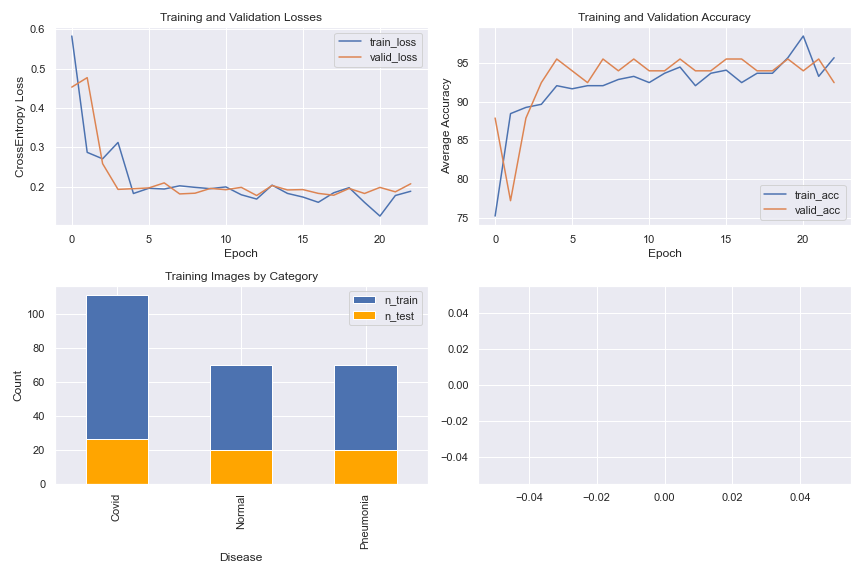

In [12]:
# save_checkpoint(model, path=checkpoint_path)
torch.save(model, 'weights\\inference.pt')  # quick save for fast inference
all_plots(cat_df, history, where='data')

Image(filename='data\\metrics.png')